In [1]:
import glob, os
import pandas as pd
import numpy as np
import pickle

from sklearn.externals import joblib
import scorecardpy as sc

import warnings
warnings.warn('ignore')

기준년월 = '2210'
savename = '기본'

/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: ignore
  # Remove the CWD from sys.path while we load stuff.


In [2]:
data_oot = pd.read_csv('./input/INPUT_2_2209.csv', 
                    encoding = 'euc-kr',
                   converters={'코드':str, '사업부':str})
data_oot.columns = list(map(lambda x: x.replace('_2209',''), data_oot.columns))

In [3]:
# 직3은 직전3개월비 평균 숫자로 들어가야함
# input_2_ : 환산_직3이 낙폭으로 들어감
# input_3_ : 환산_직3이 직3 숫자로 들어감
data = pd.read_csv('./input/INPUT_3_2210.csv', 
                    encoding = 'euc-kr',
                   converters={'코드':str, '사업부':str})
data.columns = list(map(lambda x: x.replace('_2210',''), data.columns))
data.head(1)

,코드,위촉경로,y,귀점_당월,귀점_직3,조회_당월,조회_직3,상설_당월,상설_직3,사랑온_당월,...,통합보장_당월,통합보장_직3,환산_당월,환산_직3,가동1,가동2,유지,소득,소득분류,환산분류
0,0001507864,경력,0,5.3,3.2,52.6,28.6,2,3.7,51.6,...,9,15.7,306182,222215.33333,0,0,0,264.484,1_15이상,1_15이상


In [4]:
lst = ['귀점','조회','상설','총동의','사랑온','통합보장','환산']
for l in lst:
    data[f'{l}_직3P'] = data[f'{l}_당월'] - data[f'{l}_직3']
    data_oot[f'{l}_직3P'] = data_oot[f'{l}_당월'] - data_oot[f'{l}_직3']

In [5]:
#간소화
# lst = ['y',
#        '귀점_당월', '상설_당월', '총동의_당월', '사랑온_당월', '통합보장_당월', 
#         '조회_직3P', '환산_당월'
#       ]

In [6]:
#기본
lst = ['y',
       '귀점_당월', '상설_당월', '총동의_당월', '사랑온_당월', '통합보장_당월', 
        '조회_직3P', '환산_당월'
      ,'사랑온_직3P', '상설_직3P', '총동의_직3P','통합보장_직3P','조회_당월'
       ,'유지'
      ]
# ,'귀점_직3P', 사랑온_직3P, '소득'

In [7]:
data_iv = data[lst]
oot_iv = data_oot[lst]

dt_s = sc.var_filter(data_iv, y='y')
train, test = sc.split_df(dt_s, 'y').values()

oot = sc.var_filter(oot_iv, y='y')

[INFO] filtering variables ...
[INFO] filtering variables ...


In [8]:
# bins = sc.woebin(dt_s, y = 'y', spl_val=[np.inf])
# sc.woebin_plot(bins)


# bin 수정
breaks_adj = {
    '환산_당월': [0,1,150000,300000,450000]
}
bins_adj = sc.woebin(dt_s, y="y", breaks_list=breaks_adj)

# 수정 없을때
# bins_adj = bins

[INFO] creating woe binning ...


In [9]:
# woeiv값 저장

df = pd.DataFrame(columns=['variable', 'bin', 'count', 'count_distr', 'good', 'bad', 'badprob'
                           ,'woe', 'bin_iv', 'total_iv', 'breaks', 'is_special_values'])

for k in sorted(bins_adj.keys()):
    tmp = bins_adj[k]
    df = df.append(tmp)
         
print(df.shape)

(55, 12)


In [10]:
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)
oot_woe = sc.woebin_ply(oot, bins_adj)

y_train = train_woe.loc[:,'y']
X_train = train_woe.loc[:,train_woe.columns != 'y']
y_test = test_woe.loc[:,'y']
X_test = test_woe.loc[:,train_woe.columns != 'y']

y_oot = oot_woe.loc[:,'y']
X_oot = oot_woe.loc[:,oot_woe.columns != 'y']

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [11]:
b = 50/np.log(2)
b

72.13475204444818

In [12]:
1/np.exp((462-600)/b)

6.773962498900216

In [13]:
odds0 = 1/19

In [14]:
600 + b*np.log(odds0/(1-odds0))

391.5037499278843

In [15]:
# with open('./result2차/bins_adj.pickle', 'wb') as f:
#     pickle.dump(bins_adj,f)

# with open(f"./result2차/최종모델.pkl","wb") as f:
#     pickle.dump(lr,f) 

# with open('./result2차/card.pickle', 'wb') as f:
#     pickle.dump(card,f)

In [16]:
# import pickle
# with open(f"./result2차/최종모델.pkl","r") as f:
#     lr_re = pickle.read(f) 

In [13]:
oot_pred

array([0.05990594, 0.24725607, 0.15372379, ..., 0.12694937, 0.58225529,
       0.04066847])

In [14]:
d = oot_score
d['pred'] = oot_pred
d

,score,pred
0,587.0,0.059906
1,470.0,0.247256
2,512.0,0.153724
3,596.0,0.052733
4,396.0,0.475524
...,...,...
5315,498.0,0.179314
5316,526.0,0.131697
5317,527.0,0.126949
5318,365.0,0.582255


In [22]:
d = d.sort_values(by='pred')
d['rank_pred'] = list(range(1,len(d)+1))
d = d.sort_values(by=['score','pred'],ascending=[False,True])
d['rank_score'] = list(range(1,len(d)+1))

In [24]:
d.to_csv('d.csv',encoding='utf-8-sig')

In [23]:
d[d.rank_pred!=d.rank_score]

,score,pred,rank_pred,rank_score
3101,716.0,0.010647,41,40
5071,716.0,0.010672,42,41
1639,715.0,0.010595,40,42
902,714.0,0.010956,46,45
382,713.0,0.010945,45,46
...,...,...,...,...
5129,267.0,0.844389,5312,5309
5284,267.0,0.844389,5313,5310
5141,266.0,0.843272,5306,5311
4972,266.0,0.843272,5307,5312


[-1.03883819] [[-0.32422769  0.12443028  0.17554388  0.22459988 -0.08078543  0.41845256
   0.27167928  0.21092759 -0.11629197  0.1506075   0.14236198  0.12728335
   0.00909303]]


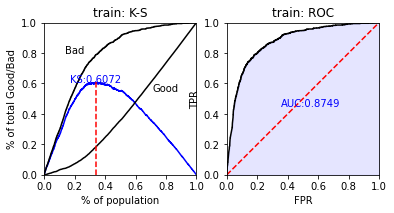

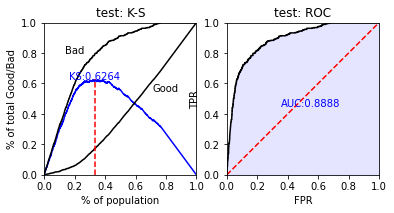

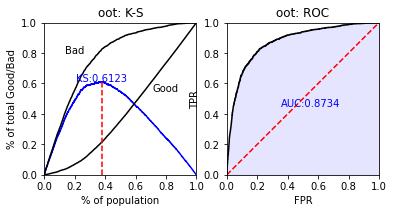

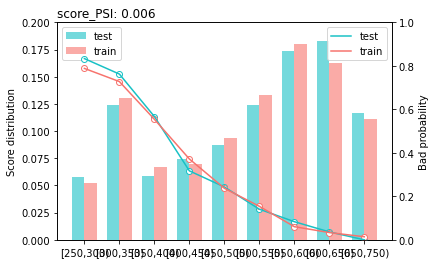

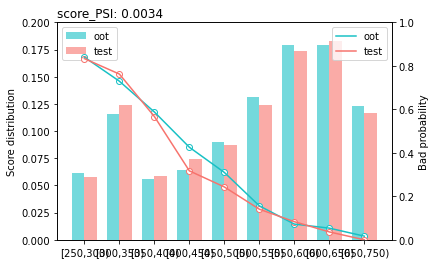

{'psi':   variable       PSI
 0    score  0.003414,
 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [11]:
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1, random_state=42)
lr.fit(X_train, y_train)
print(lr.intercept_, lr.coef_)

# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
oot_pred = lr.predict_proba(X_oot)[:,1]

# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")
oot_perf = sc.perf_eva(y_oot, oot_pred, title = "oot")

# score ------
card = sc.scorecard(bins_adj, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)
oot_score = sc.scorecard_ply(oot, card, print_step=0)

# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

sc.perf_psi(
  score = {'test':test_score, 'oot':oot_score},
  label = {'test':y_test, 'oot':y_oot}
)

In [18]:
df_coef = pd.DataFrame()
df_coef['val']=list(X_train.columns)
df_coef['coef'] = list(lr.coef_[0])
df_coef

,val,coef
0,유지_woe,0.090662
1,조회_당월_woe,0.076812
2,귀점_직3P_woe,-0.018672
3,통합보장_직3P_woe,-0.283424
4,조회_직3P_woe,0.141140
5,귀점_당월_woe,0.149800
6,소득_woe,0.914338
7,총동의_당월_woe,0.231612
8,사랑온_직3P_woe,-0.159814
9,환산_당월_woe,0.392395


In [19]:
### woe + point 저장 ----------------

card_df = pd.DataFrame()
for k in card.keys():
    tmp = card[k]
    if len(card_df) == 0:
        card_df = tmp
    else:
        card_df = card_df.append(tmp)

woe_point = df.merge(card_df, on=['variable','bin'], how='outer')
# 

In [20]:
woe_point.to_csv(f'./1_woepoint_tmp_직3P_.csv', index=False, encoding='utf-8-sig')

In [21]:
# tot_score = train_score.append(test_score).sort_index()

In [22]:
import math
1/(1+math.exp(-1*(sum(X_train.iloc[0]* lr.coef_[0]) + lr.intercept_)))  == train_pred[0]

True

--- 
## 결과저장

In [23]:
# with open(f'./result2차/bins_adj_{savename}.pickle', 'wb') as f:
#     pickle.dump(bins_adj,f)

# with open(f"./result2차/model_{savename}.pkl","wb") as f:
#     pickle.dump(lr,f) 

# with open(f'./result2차/card_{savename}.pickle', 'wb') as f:
#     pickle.dump(card,f)
    
# woe_point.to_csv(f'./result2차/1_woepoint_{savename}.csv', index=False, encoding='utf-8-sig')

---

In [23]:
woe_all = pd.concat([X_train,X_test]).sort_index()
input_all = pd.concat([train,test]).sort_index()
point_all = sc.scorecard_ply(input_all, card, print_step=0, only_total_score=False)

In [24]:
data_all = data.join(woe_all,how='left').join(point_all,how='left')
cols = data_all.columns
cols2 = ['코드', '위촉경로', 'y', 'score'] + sorted(list(set(cols)- set(['코드', '위촉경로', 'y', 'score'])))
data_all = data_all[cols2]

In [25]:
grade_lst = []
n = len(data_all)//10
for i in range(10):
    grade_lst += [i+1]*n
grade_lst += [10]*(len(data_all)-len(grade_lst))

grade_lst2 = []
n2 = len(data_all)//5
for i in range(5):
    grade_lst2 += [i+1]*n2
grade_lst2 += [5]*(len(data_all)-len(grade_lst2))

data_all = data_all.sort_values(by='score',ascending=False).reset_index(drop=True)
data_all['grade'] = grade_lst
data_all['grade2'] = grade_lst2

In [26]:
round(data_all.groupby('grade').y.mean()*100, 2)

grade
1      1.27
2      1.45
3      4.71
4      6.52
5     11.05
6     15.40
7     25.18
8     45.29
9     72.46
10    76.27
Name: y, dtype: float64

In [27]:
round(data_all.groupby('grade2').y.mean()*100, 2)

grade2
1     1.36
2     5.62
3    13.22
4    35.24
5    74.37
Name: y, dtype: float64

###

In [28]:
data_all.groupby('grade2').score.min()

grade2
1    619.0
2    567.0
3    495.0
4    365.0
5    279.0
Name: score, dtype: float64

In [29]:
data_all.drop(columns=['코드']).groupby(['grade2']).mean()

,y,score,가동1,가동2,귀점_당월,귀점_당월_points,귀점_당월_woe,귀점_직3,귀점_직3P,사랑온_당월,...,통합보장_당월_points,통합보장_당월_woe,통합보장_직3,통합보장_직3P,환산_당월,환산_당월_points,환산_당월_woe,환산_직3,환산_직3P,grade
grade2,,,,,,,,,,,,,,,,,,,,,
1,0.013587,652.874094,0.188406,0.120471,63.450543,15.177536,-1.671849,57.196739,6.253804,52.578533,...,17.305254,-1.762735,42.456612,-4.271830,642772.934783,67.586957,-2.232414,611257.571558,31515.363225,1.5
2,0.056159,592.667572,0.250000,0.236413,45.058605,9.832428,-1.075615,43.224909,1.833696,40.357699,...,14.934783,-1.511956,32.592391,-5.116848,401324.868659,42.608696,-1.414457,437508.866546,-36183.997886,3.5
3,0.132246,534.551630,0.246377,0.425725,26.573732,3.727355,-0.389198,29.651087,-3.077355,29.886141,...,7.840580,-0.773622,21.941848,-6.213587,263610.746377,26.463768,-0.881792,319532.473430,-55921.727053,5.5
4,0.352355,435.486413,0.240036,0.651268,12.325272,-2.167572,0.279312,18.905978,-6.580707,18.506884,...,-2.344203,0.243422,14.585145,-7.396739,64783.516304,-13.461957,0.449670,211338.224459,-145902.724001,7.5
5,0.743659,313.427536,0.082428,0.915761,1.481341,-8.464674,0.993067,7.942935,-6.461594,4.794384,...,-16.673007,1.657267,6.090580,-5.345109,142.522645,-45.773551,1.532906,107707.172583,-107514.583843,9.5


---

## 점수분포확인

In [32]:
data_all.score.describe()

count    5520.000000
mean      505.801449
std       122.599480
min       279.000000
25%       404.750000
50%       536.000000
75%       605.250000
max       711.000000
Name: score, dtype: float64

---

# badpoint 분석

In [ ]:
# data_all = pd.read_excel(f'./result2차/data_all_v1_가동제외.xlsx', converters={'코드':str})#.set_index('코드')

In [ ]:
grade_lst = []
n = len(data_all)//10
for i in range(10):
    grade_lst += [i+1]*n
grade_lst += [10]*(len(data_all)-len(grade_lst))

grade_lst2 = []
n2 = len(data_all)//5
for i in range(5):
    grade_lst2 += [i+1]*n2
grade_lst2 += [5]*(len(data_all)-len(grade_lst2))

data_all = data_all.sort_values(by='score',ascending=False).reset_index(drop=True)
data_all['grade'] = grade_lst
data_all['grade2'] = grade_lst2

In [ ]:
t = data_all[:]

cat1 = ['환산_당월_points']
cat2 = ['조회_당월_points','귀점_당월_points','통합보장_당월_points',   '상설_당월_points']
cat3 = ['사랑온_당월_points','총동의_당월_points']
# cat4 = [ '사랑온_직3_points', '통합보장_직3_points',       '상설_직3_points']
# cat5 = ['환산_당월_points','환산_직3_points','소득_points']
# cat6 = ['유지_points','가동1_points', '가동2_points']
# '조회_직3_points','귀점_직3_points',

cat_dict = {}
# cat_dict['cat1'] = cat1
cat_dict['cat2'] = cat2
cat_dict['cat3'] = cat3
# cat_dict['cat4'] = cat4
# cat_dict['cat5'] = cat5
# cat_dict['cat6'] = cat6
print(cat_dict)

all_cols = sum(list(cat_dict.values()),[])
goodpoint_dict = t[ all_cols ].max()
pd.DataFrame(goodpoint_dict).T



df_case = t[['코드','y','score','grade2']]
df_case['환산'] = list(t.환산_당월_points > 0) # q = np.mean(t.환산_당월_points )
# q1 = t[cat2].sum(axis=1).quantile(0.75) # np.mean(t[cat2].sum(axis=1))# 
# q2 = t[cat3].sum(axis=1).quantile(0.75) # np.mean(t[cat3].sum(axis=1)) # 
q1=60; q2=40;
df_case['활동1'] = list(t[cat2].sum(axis=1) > q1) # 18  40   60
df_case['활동2'] = list(t[cat3].sum(axis=1) > q2) # 10  31  40

df_case['case'] = list(map(lambda x,y,z: 1 if x&y&z 
            else (2 if x&~y&z 
                 else (3 if x&y&~z 
                      else (4 if ~x&y&z 
                           else (5 if x&~y&~z 
                                else (6 if ~x&y&~z  
                                      else (7 if ~x&~y&z 
                                           else 8 if ~x&~y&~z else '') ))))), df_case.환산, df_case.활동1, df_case.활동2)) 


df_case['비중'] = 1
grp = df_case.groupby(['case','환산', '활동1', '활동2']).agg({'코드':'count','비중':'sum','score':'mean','y':'mean'}).sort_values(by='y', ascending=True)
grp['비중'] = grp['비중']/5520
grp

In [ ]:

print(len(df_case[df_case.활동1])); print(len(df_case[~df_case.활동1]));
print(len(df_case[df_case.활동2])); print(len(df_case[~df_case.활동2]));
print(len(df_case[df_case.환산])), print(len(df_case[~df_case.환산]));

In [ ]:
t[cat1].sum(axis=1).describe()

In [ ]:
t[cat2].sum(axis=1).describe()

In [ ]:
t[cat3].sum(axis=1).describe()

In [ ]:
c = pd.read_csv('./input/스코어비교.csv',encoding = 'euc-kr', converters={'코드':str})
c = c[~c.유형분류.isna()]

In [ ]:
ggg = data_all.merge(c, left_on='코드', right_on='코드', how='left')


In [ ]:
ccc = c.merge(df_case, left_on='코드', right_on='코드', how='left')
# ccc.to_csv('ddd.csv', encoding='utf-8-sig')

In [ ]:
ccc.groupby(['유형분류'])[['코드']].count()

In [ ]:
ccc[ccc.유형분류=='육성&선발'].case

In [ ]:
7+4+23+43+9


In [ ]:
a1 = ccc.groupby(['case','유형분류'])[['코드']].count().pivot_table(index=['case'],columns='유형분류')


In [ ]:
ccc.groupby(['case','지역단명','유형분류'])[['코드']].count().pivot_table(index=['case'],columns=['지역단명','유형분류'])

In [ ]:
ccc.groupby(['유형분류','case']).count()

In [ ]:
ccc.groupby(['유형분류','환산', '활동1', '활동2']).count()

In [ ]:
t = data_all[:]

cat1 = ['환산_당월_points','소득_points']
cat2 = ['조회_당월_points','귀점_당월_points','통합보장_당월_points',   '상설_당월_points']
cat3 = ['사랑온_당월_points','총동의_당월_points']
# cat4 = [ '사랑온_직3_points', '통합보장_직3_points',       '상설_직3_points']
# cat5 = ['환산_당월_points','환산_직3_points','소득_points']
# cat6 = ['유지_points','가동1_points', '가동2_points']
# '조회_직3_points','귀점_직3_points',

cat_dict = {}
# cat_dict['cat1'] = cat1
cat_dict['cat2'] = cat2
cat_dict['cat3'] = cat3
# cat_dict['cat4'] = cat4
# cat_dict['cat5'] = cat5
# cat_dict['cat6'] = cat6
print(cat_dict)

all_cols = sum(list(cat_dict.values()),[])
goodpoint_dict = t[ all_cols ].max()
pd.DataFrame(goodpoint_dict).T



df_case = t[['코드','y','score','grade2']]
df_case['환산'] = list(t[cat1].sum(axis=1) > 0)
df_case['활동1'] = list(t[cat2].sum(axis=1) > 0)
df_case['활동2'] = list(t[cat3].sum(axis=1) > 0)


df_case.groupby(['환산', '활동1', '활동2']).agg({'코드':'count','score':'mean','y':'mean'}).sort_values(by='y', ascending=True)

In [ ]:
t = data_all[:]

cat1 = ['환산_당월_points','소득_points']
cat2 = ['조회_당월_points','귀점_당월_points','통합보장_당월_points',   '상설_당월_points']
cat3 = ['사랑온_당월_points','총동의_당월_points']
# cat4 = [ '사랑온_직3_points', '통합보장_직3_points',       '상설_직3_points']
# cat5 = ['환산_당월_points','환산_직3_points','소득_points']
# cat6 = ['유지_points','가동1_points', '가동2_points']
# '조회_직3_points','귀점_직3_points',

cat_dict = {}
# cat_dict['cat1'] = cat1
cat_dict['cat2'] = cat2
cat_dict['cat3'] = cat3
# cat_dict['cat4'] = cat4
# cat_dict['cat5'] = cat5
# cat_dict['cat6'] = cat6
print(cat_dict)

all_cols = sum(list(cat_dict.values()),[])
goodpoint_dict = t[ all_cols ].max()
pd.DataFrame(goodpoint_dict).T



df_case = t[['코드','y','score','grade2']]
df_case['소득'] = list(t[cat1].sum(axis=1) > 0)
# df_case['환산'] = list((t['환산_당월_points'] > 0) & (t['소득_points']>0 ))
df_case['활동1'] = list(t[cat2].sum(axis=1) > 0)
df_case['활동2'] = list(t[cat3].sum(axis=1) > 0)


df_case.groupby(['소득', '활동1', '활동2']).agg({'코드':'count','score':'mean','y':'mean'}).sort_values(by='y', ascending=True)

In [ ]:
df_case.groupby(['소득']).count()

In [ ]:
t[cat2].sum(axis=1).describe()

In [ ]:
t[cat3].sum(axis=1).describe()